In [1]:
# Add this cell at the beginning of your notebook

import sys
import subprocess

def install_and_import(package):
    try:
        __import__(package)
    except ImportError:
        print(f"{package} not found, installing...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
    finally:
        globals()[package] = __import__(package)

# List of packages to check and install if necessary
packages = ["matplotlib", "math", "time", "numpy", "torch"]

for package in packages:
    install_and_import(package)


Some miscellaneous functions

In [2]:
reduce_mean = lambda x, *args, **kwargs: x.mean(*args, **kwargs)
numpy = lambda x, *args, **kwargs: x.detach().numpy(*args, **kwargs)
to = lambda x, *args, **kwargs: x.to(*args, **kwargs)

In [3]:
%matplotlib inline
import math
import time
import numpy as np
import torch

We need some utility functions to simplify object-oriented programming in jupyter notebooks.

In [4]:
def add_to_class(Class): #@save
    """ Register functions as methods in created class."""
    def wrapper(obj):
        setattr(Class, obj.__name__, obj)
    return wrapper

We also utilize another utility class that saved the constructor params when passed in.

In [5]:
import inspect


class HyperParameters: #@save
    def save_hyperparameters(self, ignore=[]):
        frame = inspect.currentframe().f_back
        _,_,_, local_vars = inspect.getargvalues(frame)
        self.hparams = {k:v for k, v in local_vars.items()
                        if k not in set(ignore+['self']) and not k.startswith('_')}
        for k, v in self.hparams.items():
            setattr(self, k, v)

This final utility allows us to plot experiment progress interactively while it is going on.

In [6]:
from matplotlib_inline import backend_inline
import matplotlib.pyplot as plt
import collections
from IPython import display

class ProgressBoard(HyperParameters):
    """The board that plots data points in animation.

    Defined in :numref:`sec_oo-design`"""

    def __init__(self, xlabel=None, ylabel=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 ls=['-', '--', '-.', ':'], colors=['C0', 'C1', 'C2', 'C3'],
                 fig=None, axes=None, figsize=(3.5, 2.5), display=True):
        self.save_hyperparameters()

    def draw(self, x, y, label, every_n=1):
        raise NotImplemented

    def draw(self, x, y, label, every_n=1):
        """Defined in :numref:`sec_utils`"""
        Point = collections.namedtuple('Point', ['x', 'y'])
        if not hasattr(self, 'raw_points'):
            self.raw_points = collections.OrderedDict()
            self.data = collections.OrderedDict()
        if label not in self.raw_points:
            self.raw_points[label] = []
            self.data[label] = []
        points = self.raw_points[label]
        line = self.data[label]
        points.append(Point(x, y))
        if len(points) != every_n:
            return
        mean = lambda x: sum(x) / len(x)
        line.append(Point(mean([p.x for p in points]),
                          mean([p.y for p in points])))
        points.clear()
        if not self.display:
            return
        backend_inline.set_matplotlib_formats('svg')
        if self.fig is None:
            self.fig = plt.figure(figsize=self.figsize)
        plt_lines, labels = [], []
        for (k, v), ls, color in zip(self.data.items(), self.ls, self.colors):
            plt_lines.append(plt.plot([p.x for p in v], [p.y for p in v],
                                          linestyle=ls, color=color)[0])
            labels.append(k)
        axes = self.axes if self.axes else plt.gca()
        if self.xlim: axes.set_xlim(self.xlim)
        if self.ylim: axes.set_ylim(self.ylim)
        if not self.xlabel: self.xlabel = self.x
        axes.set_xlabel(self.xlabel)
        axes.set_ylabel(self.ylabel)
        axes.set_xscale(self.xscale)
        axes.set_yscale(self.yscale)
        axes.legend(plt_lines, labels)
        display.display(self.fig)
        display.clear_output(wait=True)

Now we need a way to define an abstract represenation of all our machine leanring models.
The module class is the base class of all modles we will implement. We need this class to:
*   store learnable parameters using the `__init__` method
*   the `training_step` method return the loss value
*   lastly, a `configure_optimizers` method that returns the optimization method or a list of them that is used to update the learnable parameters of the model

In [7]:
class Module(torch.nn.Module, HyperParameters):
    def __init__(self, plot_train_per_epoch=2, plot_valid_per_epoch=1):
        super().__init__()
        self.save_hyperparameters()
        self.board = ProgressBoard()

    def loss(self, y_hat, y):
        raise NotImplementedError

    def forward(self, X):
        assert hasattr(self, 'net'), 'Neural network is defined'
        return self.net(X)

    def plot(self, key, value, train):
        """Plot a point in animation."""
        assert hasattr(self, 'trainer'), 'Trainer is not inited'
        self.board.xlabel = 'epoch'
        if train:
            x = self.trainer.train_batch_idx / \
                self.trainer.num_train_batches
            n = self.trainer.num_train_batches / \
                self.plot_train_per_epoch
        else:
            x = self.trainer.epoch + 1
            n = self.trainer.num_val_batches / \
                self.plot_valid_per_epoch
        self.board.draw(x, numpy(to(value, torch.device('cpu'))),
                        ('train_' if train else 'val_') + key,
                        every_n=int(n))

    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=True)
        return l

    def validation_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=False)

    def configure_optimizers(self):
        raise NotImplementedError

    def configure_optimizers(self):
        """Defined in :numref:`sec_classification`"""
        return torch.optim.SGD(self.parameters(), lr=self.lr)

    def apply_init(self, inputs, init=None):
        """Defined in :numref:`sec_lazy_init`"""
        self.forward(*inputs)
        if init is not None:
            self.net.apply(init)

In [8]:
class DataModule(HyperParameters):
    def __init__(self, root='../data', num_workers=4):
        self.save_hyperparameters()
    
    def get_dataloader(self, train: bool):
        raise NotImplementedError
    
    def train_dataloader(self):
        return self.get_dataloader(True)
    
    def val_dataloader(self):
        return self.get_dataloader(False)

The `Trainer` class trains the learnable parameters in the Module Class with data specified in DataModule. The key method to this interface is the `fit` method which accepts the model of type `Module` and the data of type `DataModule`. 
The interface iterates over the entire dataset `max_epochs` times to train the model.

In [9]:
class Trainer(HyperParameters):
    def __init__(self, max_epochs, num_gpus=0, gradient_clip_val=0):
        self.save_hyperparameters()
        assert num_gpus == 0, 'No GPU support yet'

    def prepare_data(self, data: DataModule):
        self.train_dataloader = data.train_dataloader()
        self.val_dataloader = data.val_dataloader()
        self.num_train_batches = len(self.train_dataloader)
        self.num_val_batches = (len(self.val_dataloader) if self.val_dataloader is not None else 0)

    def prepare_model(self, model):
        model.trainer = self
        model.board.xlim = [0, self.max_epochs]
        self.model = model

    def fit(self, model: Module, data: DataModule):
        self.prepare_data(data)
        self.prepare_model(model)
        self.optim = model.configure_optimizers()
        self.epoch = 0
        self.train_batch_idx = 0
        self.val_batch_idx = 0
        for self.epoch in range(self.max_epochs):
            self.fit_epoch()

    def fit_epoch(self):
        raise NotImplementedError

Synthetic Regression Data

In [10]:
import random
import torch

class SyntheticRegressionData(DataModule):
    """Synthetic data for linear regression"""
    def __init__(self, w, b, noise=0.01, num_train=1000, num_val=1000, batch_size=32):
        super().__init__()
        self.save_hyperparameters()
        n = num_train + num_val
        self.X = torch.randn(n, len(w))
        noise = torch.randn(n, 1) + noise
        self.y = torch.matmul(self.X, w.reshape((-1, 1))) + b + noise

testing our `SyntheticRegressionData` API

In [11]:
data = SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
print('features:', data.X[0],'\nlabel:', data.y[0])

features: tensor([-0.1400, -1.5097]) 
label: tensor([8.5155])


In [12]:
@add_to_class(SyntheticRegressionData)
def get_tensorloader(self, tensors, train, indices=slice(0, None)):
    tensors = tuple(a[indices] for a in tensors)
    dataset = torch.utils.data.TensorDataset(*tensors)
    return torch.utils.data.DataLoader(dataset, self.batch_size, shuffle=train)

@add_to_class(SyntheticRegressionData)
def get_dataloader(self, train):
    i = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader((self.X, self.y), train, i)

In [13]:
class LinearRegressionScratch(Module):
    def __init__(self, num_inputs, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.w = torch.normal(0, sigma, (num_inputs, 1), requires_grad=True)
        self.b = torch.zeros(1, requires_grad=True)

In [14]:
@add_to_class(LinearRegressionScratch)
def forward(self, X: torch.Tensor) -> torch.Tensor:
    return torch.matmul(X, self.w) + self.b

@add_to_class(LinearRegressionScratch)
def loss(self, y_hat: torch.Tensor, y: torch.Tensor):
    l = (y_hat - y) ** 2 / 2
    return l.mean()

Now we define the optimizer that dictates how our parameters should be tuned. This class usually tunes hyperparameters for larger mini batches but for the sake of learning this in the initial phases, we will opt from tuning any hyperparams

In [15]:
class SGD(HyperParameters):
    def __init__(self, params, lr):
        self.save_hyperparameters()

    def step(self):
        for param in self.params:
            param -= self.lr * param.grad

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()

We add another method to our model that will return an instance of the configured optimizer

In [16]:
@add_to_class(LinearRegressionScratch)
def configure_optimizers(self):
    return SGD([self.w, self.b], self.lr)

In [17]:
@add_to_class(Trainer)
def prepare_batch(self, batch):
    return batch

@add_to_class(Trainer)
def fit_epoch(self):
    self.model.train()
    for batch in self.train_dataloader:
        loss = self.model.training_step(self.prepare_batch(batch))
        self.optim.zero_grad()
        with torch.no_grad():
            loss.backward()
            if self.gradient_clip_val > 0: # To be discussed later
                self.clip_gradients(self.gradient_clip_val, self.model)
            self.optim.step()
        self.train_batch_idx += 1
    if self.val_dataloader is None:
        return
    for batch in self.val_dataloader:
        with torch.no_grad():
            self.model.validation_step(self.prepare_batch(batch))
        self.val_batch_idx += 1

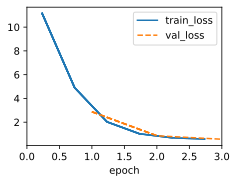

In [18]:
model = LinearRegressionScratch(2, lr=0.03)
data = SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = Trainer(max_epochs=3)
trainer.fit(model, data)